## The goal of this notebook is to test the optimization of DS sample paths.

Let's start by creating a dummy GP model.

Using a 1D model for ease of plotting sample paths.

In [1]:
import torch
import gpytorch
import botorch
from torch import Tensor

device = "cuda" if torch.cuda.is_available() else "cpu"

num_train = 20
dim = 1
train_X = torch.rand(num_train, dim, device=device)
train_Y = torch.randn(num_train, 1, device=device)

model = botorch.models.SingleTaskGP(
    train_X, train_Y,
)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
_ = botorch.fit_gpytorch_model(mll)


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


Construct the decoupled sampler for this model.

We will focus on a single sample path to simplify grad operations.

In [2]:
from gp_sampling import decoupled_sampler
num_samples = 2

ds = decoupled_sampler(
    model=model,
    sample_shape=torch.Size([num_samples]),
    num_basis=256,
)

# dummy test
print(ds(torch.rand(2, dim, device=device)).shape)

torch.Size([2, 2, 1])


Let's check whether the output has grad.

In [3]:
test_X = torch.rand(2, dim, device=device, requires_grad=True)
samples = ds(test_X)

print(f"Samples: {samples}, \n"
      f"requires grad: {samples.requires_grad}")

grad = torch.autograd.grad(samples.sum(), test_X)
print(f"Grad: {grad}")


Samples: tensor([[[-0.2563],
         [ 0.7565]],

        [[ 0.0446],
         [ 0.6823]]], grad_fn=<AddBackward0>), 
requires grad: True
Grad: (tensor([[-6.3482],
        [ 0.2788]]),)


Let's plot the sample path and see if simple gradient descent gets us to a local
minimizer.

We are only optimizing the first sample path, plotted in blue.

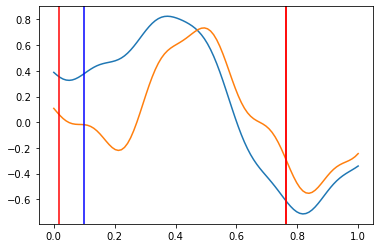

In [4]:
import matplotlib.pyplot as plt

if dim != 1:
    raise RuntimeError("Cannot plot sample paths with dim > 1!")

plot_X = torch.linspace(0, 1, 100).to(device).reshape(-1, 1)
plot_Y = ds(plot_X)
for i in range(num_samples):
    plt.plot(
        plot_X.detach().cpu(), plot_Y[i].detach().cpu()
    )

X = torch.rand(1, 1, device=device, requires_grad=True)
lr = 0.05

for i in range(1000):
    Y = ds(X)[0]
    g = torch.autograd.grad(Y, X)[0]
    X = X - lr * g
    X = X.clamp(0, 1)

plt.axvline(X.detach().cpu(), c="b")

# How about multi-start SGD?

X = torch.rand(3, 1, device=device, requires_grad=True)

for i in range(1000):
    Y = ds(X)[0]
    g = torch.autograd.grad(Y.sum(), X)[0]
    X = X - lr * g
    X = X.clamp(0, 1)

for x_ in X:
    plt.axvline(x_.detach().cpu(), c="r")


Step size appears to be a factor here (to see why, run it multiple times). To rule this
out, let's try using LBFGS via BoTorch.

Note that below maximizes (blue sample path) whereas the previous ones were minimization.

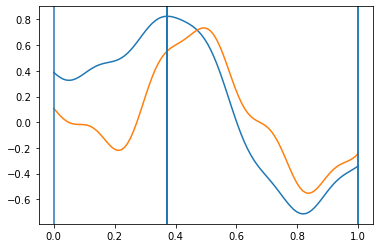

In [5]:
# plot the sample path
plot_X = torch.linspace(0, 1, 100).to(device).reshape(-1, 1)
plot_Y = ds(plot_X)
for i in range(num_samples):
    plt.plot(
        plot_X.detach().cpu(), plot_Y[i].detach().cpu()
    )

def wrapper(f):
    def wrapped(X):
        return f(X)[0]
    return wrapped

solutions, values = botorch.gen_candidates_scipy(
    initial_conditions=torch.linspace(0, 1, 10).to(device).reshape(-1, 1),
    acquisition_function=wrapper(ds),
    lower_bounds=0.,
    upper_bounds=1.,
)

for x_ in solutions:
    plt.axvline(x_.detach().cpu())

In [6]:
# Verifying the batch behavior of DS.
# DS accepts batch_shape x sample_shape x n x d inputs
# The output is the same shape as the input (except last dim)
# or is broadcasted to sample_shape x n x 1
test_X = torch.rand(4, 2, 3, dim)
print(ds(test_X).shape)
test_X = torch.tensor([
    [[0.], [0.2]], [[0.8], [1.]]
])
print(ds(test_X))
print(ds(test_X[0]))

torch.Size([4, 2, 3, 1])
tensor([[[ 0.3882],
         [ 0.4773]],

        [[-0.4785],
         [-0.2441]]], grad_fn=<AddBackward0>)
tensor([[[ 0.3882],
         [ 0.4773]],

        [[ 0.1080],
         [-0.2104]]], grad_fn=<AddBackward0>)


In a batch TS setting, we will want to optimize multiple sample paths in parallel.

There are two ways I can think of for doing this.

One is to generate the DS object with the full sample shape and optimize each sample
path independently, masking out the remaining sample paths.

Other alternative is to generate a DS object for each sample path independently. My
guess is this is the more wasteful approach, since constructing the DS object is the
expensive part.

DS actually supports independent evaluations of the sample paths. We will use this as
the third alternative below. This is expected to be the clear winner here.

### `batched_optimize` is the clear winner. I'll implement this in `gp_sampling.thompson_samplers`.

In [7]:
# Set some common parameters / imports
from botorch.optim import optimize_acqf
num_basis = 256
num_restarts = 10

# define the model here as well

In [8]:
def masked_optimize(model, num_samples, seed=None) -> Tensor:
    r"""
    This will take in a model, generate a DS object with num_samples sample paths, and
    optimize these individually using a masked approach.
    """
    if seed:
        torch.manual_seed(seed)
    ds = decoupled_sampler(
        model=model,
        sample_shape=torch.Size([num_samples]),
        num_basis=256,
    )
    # this is tested and working
    def separator(f, k):
        r"""Return only the output for the k^th sample path"""
        def separated(X):
            return f(X)[k]
        return separated

    solutions = list()
    for k in range(num_samples):
        # optimize sample paths 1 by 1
        sol, val = botorch.gen_candidates_scipy(
            initial_conditions=torch.rand(num_restarts, dim, device=device),
            acquisition_function=separator(ds, k),
            lower_bounds=0.,
            upper_bounds=1.,
        )
        argmax = val.argmax(dim=-2)
        solutions.append(sol[argmax])
    return torch.cat(solutions, dim=0)

print(masked_optimize(model, 2))  # for testing

tensor([[0.5059],
        [0.0000]])


In [9]:
def sequential_optimize(model, num_samples, seed=None) -> Tensor:
    r"""
    In this version, we will generate a new DS object for each sample path and optimize
     it. Likely much less efficient but worth comparing with.
    """
    if seed:
        torch.manual_seed(seed)
    # tested and working
    solutions = list()
    for _ in range(num_samples):
        ds = decoupled_sampler(
            model=model,
            sample_shape=torch.Size([1]),
            num_basis=256,
        )
        sol, val = botorch.gen_candidates_scipy(
            initial_conditions=torch.rand(num_restarts, dim, device=device),
            acquisition_function=ds,
            lower_bounds=0.,
            upper_bounds=1.,
        )
        argmax = val.argmax(dim=-2)
        solutions.append(sol[argmax].squeeze(0))
    return torch.cat(solutions, dim=0)

print(sequential_optimize(model, 2))  # testing


tensor([[0.4934],
        [0.3771]])


In [10]:
def batched_optimize(model, num_samples, seed=None) -> Tensor:
    r"""
    This optimizes sample paths using batch evaluations of DS samples.
    DS accepts batch_shape x num_samples x n x d input, and returns
    batch_shape x num_samples x n x 1 output.
    Ignoring batch_shape here, we can specify the samples we want to evaluate
    for each sample path by supplying num_samples x n x d input.
    n here will be the num_restarts, among which we can choose the argmax to
    get the TS sample.
    """
    # tested and working
    if seed:
        torch.manual_seed(seed)
    ds = decoupled_sampler(
        model=model,
        sample_shape=torch.Size([num_samples]),
        num_basis=256,
    )
    sol, val = botorch.gen_candidates_scipy(
        initial_conditions=torch.rand(num_samples, num_restarts, dim, device=device),
        acquisition_function=ds,
        lower_bounds=0.,
        upper_bounds=1.,
    )
    argmax = val.argmax(dim=-2)
    return torch.gather(sol, dim=-2, index=argmax.unsqueeze(-1))

print(batched_optimize(model, 2))  # testing

tensor([[[0.4686]],

        [[0.4090]]])


Let's compare time it takes for each of these methods to draw a number of TS samples.

In [11]:
num_train = 20
dim = 4
train_X = torch.rand(num_train, dim, device=device)
train_Y = torch.randn(num_train, 1, device=device)

model = botorch.models.SingleTaskGP(
    train_X, train_Y,
)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
_ = botorch.fit_gpytorch_model(mll)

In [12]:
%load_ext memory_profiler

%timeit masked_optimize(model, 50)
%memit masked_optimize(model, 50)

4.18 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
peak memory: 687.95 MiB, increment: 0.02 MiB


In [13]:
%timeit sequential_optimize(model, 50)
%memit sequential_optimize(model, 50)

4.31 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
peak memory: 718.67 MiB, increment: 0.02 MiB


In [14]:
%timeit batched_optimize(model, 50)
%memit batched_optimize(model, 50)

604 ms ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
peak memory: 805.11 MiB, increment: 0.02 MiB


Also with a small number of samples.

In [15]:
%timeit masked_optimize(model, 5)

478 ms ± 150 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit sequential_optimize(model, 5)

432 ms ± 76.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit batched_optimize(model, 5)

147 ms ± 9.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Lastly, with a single sample. Expecting identical behavior here.

In [18]:
%timeit masked_optimize(model, 1)

86.2 ms ± 7.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit sequential_optimize(model, 1)

84.9 ms ± 7.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit batched_optimize(model, 1)

86.6 ms ± 5.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
